# Nivy Area Urban Development Impact Analysis

## Objective
This notebook analyzes the impact of urban development in the Nivy area (Bratislava) by examining:
1. **Business Ecosystem Transformation** - Changes in business density, types, and distribution
2. **Spatial Impact Zone Analysis** - Buffer-based analysis around Nivy shopping center

## Data Sources
- Small businesses data (76K+ records from Bratislava region)
- Nivy area polygon boundary (GeoJSON)
- Brownfield development data

## Key Research Questions
1. How has business density changed around the Nivy area?
2. What types of businesses have emerged near this major development?
3. What is the spatial extent of Nivy's influence on local business ecosystem?
4. How do brownfield sites relate to new business development?

## 1. Data Loading and Initial Exploration

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import json
from shapely.geometry import Point, Polygon
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
print("Libraries imported successfully!")

Libraries imported successfully!


In [15]:
# Load the datasets
businesses_df = pd.read_csv('../python-service/data/small_businesses_all.csv')
brownfields_df = pd.read_csv('../python-service/data/brownfields_all.csv')

# Load Nivy area polygon
with open('../python-service/data/nivy_area.geojson', 'r') as f:
    nivy_geojson = json.load(f)

print(f"Businesses dataset shape: {businesses_df.shape}")
print(f"Brownfields dataset shape: {brownfields_df.shape}")
print(f"Nivy area type: {nivy_geojson['type']}")

# Display basic information about businesses dataset
print("\n" + "="*50)
print("BUSINESSES DATASET OVERVIEW")
print("="*50)
print(businesses_df.info())

print("\n" + "="*50)
print("FIRST 5 BUSINESS RECORDS")
print("="*50)
print(businesses_df.head())

Businesses dataset shape: (76067, 12)
Brownfields dataset shape: (113, 27)
Nivy area type: FeatureCollection

BUSINESSES DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76067 entries, 0 to 76066
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   osm_id               76067 non-null  int64  
 1   gen_cat              76067 non-null  object 
 2   detail_cat           76067 non-null  object 
 3   latitude             76067 non-null  float64
 4   longitude            76067 non-null  float64
 5   name                 66650 non-null  object 
 6   tags                 76067 non-null  object 
 7   year                 76067 non-null  int64  
 8   datetime             76067 non-null  object 
 9   functional_category  76067 non-null  object 
 10  region               76067 non-null  object 
 11  source_directory     76067 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage:

## 2. Brownfield Development Impact Analysis: Inside vs Outside Zones

This analysis focuses on the former brownfield area (now Nivy development) and its immediate surroundings:
- **Inside Zone**: The brownfield area itself (core development site)
- **Outside Zone**: 500m buffer around the brownfield area

This comparison shows how business concentration differs between the redeveloped brownfield site and its immediate neighborhood.

In [18]:
# Extract brownfield area polygon and create zones
brownfield_coords = nivy_geojson['features'][0]['geometry']['coordinates'][0]
brownfield_polygon = Polygon(brownfield_coords)

# Create 500m buffer zone AROUND the brownfield area
buffer_distance_degrees = 0.0045  # ~500m in degrees at this latitude

# Create the outside zone (500m buffer ring around brownfield)
buffered_area = brownfield_polygon.buffer(buffer_distance_degrees)
# Outside zone is the buffer ring (buffered area minus the core brownfield)
outside_ring = buffered_area.difference(brownfield_polygon)

# Calculate areas
# At 48°N: 1° longitude ≈ 74.6 km, 1° latitude ≈ 111 km
km_per_deg_lon = 74.6
km_per_deg_lat = 111
approx_km2_per_deg2 = km_per_deg_lon * km_per_deg_lat

brownfield_area_deg2 = brownfield_polygon.area
brownfield_area_km2 = brownfield_area_deg2 * approx_km2_per_deg2

outside_ring_area_deg2 = outside_ring.area
outside_ring_area_km2 = outside_ring_area_deg2 * approx_km2_per_deg2

# Calculate center point for mapping
brownfield_center_lng = sum(coord[0] for coord in brownfield_coords) / len(brownfield_coords)
brownfield_center_lat = sum(coord[1] for coord in brownfield_coords) / len(brownfield_coords)
brownfield_center = Point(brownfield_center_lng, brownfield_center_lat)

print("="*60)
print("BROWNFIELD DEVELOPMENT ZONES DEFINITION")
print("="*60)
print(f"Brownfield center: ({brownfield_center_lat:.6f}, {brownfield_center_lng:.6f})")
print(f"\nINSIDE Zone (Brownfield core area): {brownfield_area_km2:.3f} km²")
print(f"OUTSIDE Zone (500m buffer ring): {outside_ring_area_km2:.3f} km²")
print(f"Total analysis area: {(brownfield_area_km2 + outside_ring_area_km2):.3f} km²")

BROWNFIELD DEVELOPMENT ZONES DEFINITION
Brownfield center: (48.142908, 17.125548)

INSIDE Zone (Brownfield core area): 0.587 km²
OUTSIDE Zone (500m buffer ring): 2.241 km²
Total analysis area: 2.828 km²


In [19]:
# Clean and prepare business data
businesses_clean = businesses_df.copy()

# Remove rows with missing coordinates
businesses_clean = businesses_clean.dropna(subset=['latitude', 'longitude'])

# Filter for valid coordinates (Bratislava region)
businesses_clean = businesses_clean[
    (businesses_clean['latitude'].between(48.0, 48.3)) &
    (businesses_clean['longitude'].between(16.8, 17.3))
]

# Create geometry points for each business
businesses_clean['geometry'] = businesses_clean.apply(
    lambda row: Point(row['longitude'], row['latitude']), axis=1
)

print(f"Cleaned businesses dataset: {len(businesses_clean):,} records")
print(f"Year range: {businesses_clean['year'].min()} - {businesses_clean['year'].max()}")

# Classify businesses into INSIDE and OUTSIDE zones
businesses_clean['in_brownfield'] = businesses_clean['geometry'].apply(
    lambda pt: brownfield_polygon.contains(pt)
)
businesses_clean['in_outside_ring'] = businesses_clean['geometry'].apply(
    lambda pt: outside_ring.contains(pt)
)

# For initial analysis, focus on 2025 data
businesses_2025 = businesses_clean[businesses_clean['year'] == 2025]
inside_zone = businesses_2025[businesses_2025['in_brownfield'] == True]
outside_zone = businesses_2025[businesses_2025['in_outside_ring'] == True]

print("\n" + "="*60)
print("BUSINESS CONCENTRATION (2025): INSIDE vs OUTSIDE ZONES")
print("="*60)
print(f"\nINSIDE Zone (Brownfield core):")
print(f"  • Total businesses (2025): {len(inside_zone):,}")
print(f"  • Area: {brownfield_area_km2:.3f} km²")
print(f"  • Density: {len(inside_zone)/brownfield_area_km2 if brownfield_area_km2 > 0 else 0:.1f} businesses/km²")

print(f"\nOUTSIDE Zone (500m buffer ring):")
print(f"  • Total businesses (2025): {len(outside_zone):,}")
print(f"  • Area: {outside_ring_area_km2:.3f} km²")
print(f"  • Density: {len(outside_zone)/outside_ring_area_km2 if outside_ring_area_km2 > 0 else 0:.1f} businesses/km²")

# Calculate development scores
inside_score = len(inside_zone)
outside_score = len(outside_zone)
inside_density = len(inside_zone) / brownfield_area_km2 if brownfield_area_km2 > 0 else 0
outside_density = len(outside_zone) / outside_ring_area_km2 if outside_ring_area_km2 > 0 else 0

print("\n" + "="*60)
print("DEVELOPMENT SCORES (2025 Snapshot)")
print("="*60)
print(f"INSIDE Score (absolute): {inside_score:,} businesses")
print(f"OUTSIDE Score (absolute): {outside_score:,} businesses")
print(f"\nINSIDE Score (density): {inside_density:.1f} businesses/km²")
print(f"OUTSIDE Score (density): {outside_density:.1f} businesses/km²")

if outside_density > 0:
    print(f"\n🎯 Density Ratio: {inside_density/outside_density:.2f}x")
    if inside_density > outside_density:
        print(f"   (Brownfield core has {inside_density/outside_density:.2f}x higher business density)")
    else:
        print(f"   (Buffer zone has {outside_density/inside_density:.2f}x higher business density)")
else:
    print(f"\n🎯 Inside density: {inside_density:.1f} businesses/km²")


Cleaned businesses dataset: 25,015 records
Year range: 2014 - 2025

BUSINESS CONCENTRATION (2025): INSIDE vs OUTSIDE ZONES

INSIDE Zone (Brownfield core):
  • Total businesses (2025): 434
  • Area: 0.587 km²
  • Density: 739.5 businesses/km²

OUTSIDE Zone (500m buffer ring):
  • Total businesses (2025): 588
  • Area: 2.241 km²
  • Density: 262.3 businesses/km²

DEVELOPMENT SCORES (2025 Snapshot)
INSIDE Score (absolute): 434 businesses
OUTSIDE Score (absolute): 588 businesses

INSIDE Score (density): 739.5 businesses/km²
OUTSIDE Score (density): 262.3 businesses/km²

🎯 Density Ratio: 2.82x
   (Brownfield core has 2.82x higher business density)


## 3. Temporal Analysis: Brownfield Core Development (2014 → 2018 → 2025)

Tracking business growth within the brownfield core area across three key time periods:
- **2014**: Pre-development baseline
- **2018**: Mid-development phase
- **2025**: Current state (post-development)

In [20]:
# Filter businesses for each time period within the brownfield core
years_to_analyze = [2014, 2018, 2025]
temporal_results = []

for year in years_to_analyze:
    year_data = businesses_clean[
        (businesses_clean['year'] == year) & 
        (businesses_clean['in_brownfield'] == True)
    ]
    
    count = len(year_data)
    density = count / brownfield_area_km2 if brownfield_area_km2 > 0 else 0
    
    temporal_results.append({
        'Year': year,
        'Business Count': count,
        'Density (per km²)': round(density, 1),
        'Area (km²)': round(brownfield_area_km2, 3)
    })

# Create DataFrame for easy viewing
temporal_df = pd.DataFrame(temporal_results)

print("="*70)
print("TEMPORAL ANALYSIS: BROWNFIELD CORE BUSINESS GROWTH")
print("="*70)
print(temporal_df.to_string(index=False))

# Calculate growth metrics
count_2014 = temporal_df[temporal_df['Year'] == 2014]['Business Count'].values[0]
count_2018 = temporal_df[temporal_df['Year'] == 2018]['Business Count'].values[0]
count_2025 = temporal_df[temporal_df['Year'] == 2025]['Business Count'].values[0]

growth_2014_2018 = count_2018 - count_2014
growth_2018_2025 = count_2025 - count_2018
growth_2014_2025 = count_2025 - count_2014

print("\n" + "="*70)
print("GROWTH METRICS")
print("="*70)
print(f"2014 → 2018: {growth_2014_2018:+,} businesses ({(growth_2014_2018/count_2014*100) if count_2014 > 0 else 0:+.1f}%)")
print(f"2018 → 2025: {growth_2018_2025:+,} businesses ({(growth_2018_2025/count_2018*100) if count_2018 > 0 else 0:+.1f}%)")
print(f"2014 → 2025: {growth_2014_2025:+,} businesses ({(growth_2014_2025/count_2014*100) if count_2014 > 0 else 0:+.1f}%)")

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)
if growth_2014_2025 > 0:
    print(f"✅ The brownfield core has seen {growth_2014_2025:,} new businesses over 11 years")
    print(f"📈 Average growth: {growth_2014_2025/11:.1f} businesses per year")
else:
    print(f"⚠️  Business count has changed by {growth_2014_2025:,} businesses")
    
# Identify which period had faster growth
if abs(growth_2014_2018) > abs(growth_2018_2025):
    print(f"🚀 Fastest growth period: 2014-2018 ({abs(growth_2014_2018)} businesses in 4 years)")
else:
    print(f"🚀 Fastest growth period: 2018-2025 ({abs(growth_2018_2025)} businesses in 7 years)")

TEMPORAL ANALYSIS: BROWNFIELD CORE BUSINESS GROWTH
 Year  Business Count  Density (per km²)  Area (km²)
 2014              33               56.2       0.587
 2018              44               75.0       0.587
 2025             434              739.5       0.587

GROWTH METRICS
2014 → 2018: +11 businesses (+33.3%)
2018 → 2025: +390 businesses (+886.4%)
2014 → 2025: +401 businesses (+1215.2%)

KEY INSIGHTS
✅ The brownfield core has seen 401 new businesses over 11 years
📈 Average growth: 36.5 businesses per year
🚀 Fastest growth period: 2018-2025 (390 businesses in 7 years)


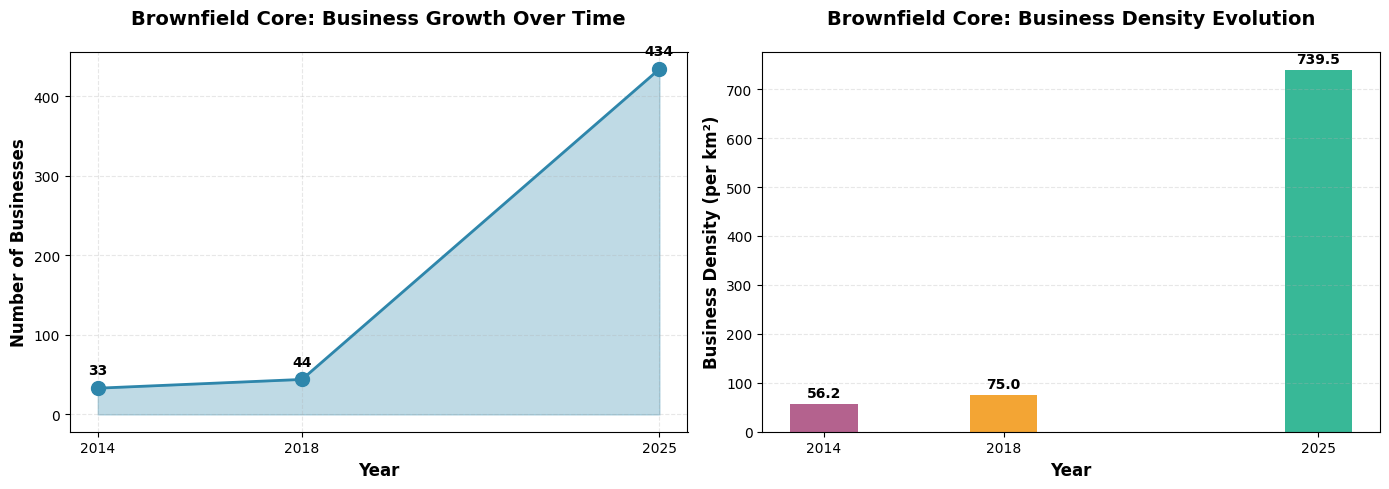


📊 Temporal visualization complete!


In [21]:
# Visualization: Temporal growth comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Business count over time
axes[0].plot(temporal_df['Year'], temporal_df['Business Count'], 
             marker='o', linewidth=2, markersize=10, color='#2E86AB')
axes[0].fill_between(temporal_df['Year'], temporal_df['Business Count'], 
                      alpha=0.3, color='#2E86AB')
axes[0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Businesses', fontsize=12, fontweight='bold')
axes[0].set_title('Brownfield Core: Business Growth Over Time', 
                   fontsize=14, fontweight='bold', pad=20)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_xticks(temporal_df['Year'])

# Add value labels on points
for idx, row in temporal_df.iterrows():
    axes[0].annotate(f"{int(row['Business Count']):,}", 
                     (row['Year'], row['Business Count']),
                     textcoords="offset points", xytext=(0,10), 
                     ha='center', fontsize=10, fontweight='bold')

# Plot 2: Business density over time
axes[1].bar(temporal_df['Year'], temporal_df['Density (per km²)'], 
            color=['#A23B72', '#F18F01', '#06A77D'], alpha=0.8, width=1.5)
axes[1].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Business Density (per km²)', fontsize=12, fontweight='bold')
axes[1].set_title('Brownfield Core: Business Density Evolution', 
                   fontsize=14, fontweight='bold', pad=20)
axes[1].grid(True, alpha=0.3, linestyle='--', axis='y')
axes[1].set_xticks(temporal_df['Year'])

# Add value labels on bars
for idx, row in temporal_df.iterrows():
    axes[1].text(row['Year'], row['Density (per km²)'] + (max(temporal_df['Density (per km²)']) * 0.02),
                 f"{row['Density (per km²)']:.1f}", 
                 ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Temporal visualization complete!")

## 4. Interactive Heatmap: Business Concentration Visualization

Interactive map showing business density across the brownfield core and buffer zone.

In [22]:
# Create interactive heatmap for 2025 business concentration
# Filter businesses in the analysis area (brownfield + buffer)
businesses_in_area = businesses_2025[
    (businesses_2025['in_brownfield'] == True) | 
    (businesses_2025['in_outside_ring'] == True)
]

# Create base map centered on brownfield
m = folium.Map(
    location=[brownfield_center_lat, brownfield_center_lng],
    zoom_start=15,
    tiles='OpenStreetMap'
)

# Add brownfield polygon
folium.GeoJson(
    nivy_geojson,
    name='Brownfield Core Area',
    style_function=lambda x: {
        'fillColor': '#FF6B6B',
        'color': '#C92A2A',
        'weight': 3,
        'fillOpacity': 0.2,
        'dashArray': '5, 5'
    }
).add_to(m)

# Add buffer ring outline
buffer_coords = list(buffered_area.exterior.coords)
buffer_geojson = {
    'type': 'Feature',
    'geometry': {
        'type': 'Polygon',
        'coordinates': [buffer_coords]
    }
}

folium.GeoJson(
    buffer_geojson,
    name='500m Buffer Zone',
    style_function=lambda x: {
        'fillColor': 'transparent',
        'color': '#4ECDC4',
        'weight': 2,
        'fillOpacity': 0,
        'dashArray': '10, 5'
    }
).add_to(m)

# Prepare heatmap data (latitude, longitude pairs)
heat_data = [[row['latitude'], row['longitude']] for idx, row in businesses_in_area.iterrows()]

# Add heatmap layer
HeatMap(
    heat_data,
    name='Business Density Heatmap',
    min_opacity=0.3,
    max_opacity=0.8,
    radius=15,
    blur=20,
    gradient={
        0.0: '#313695',
        0.25: '#4575B4', 
        0.5: '#FEE090',
        0.75: '#F46D43',
        1.0: '#A50026'
    }
).add_to(m)

# Add individual business markers (sample for performance)
sample_size = min(100, len(businesses_in_area))
businesses_sample = businesses_in_area.sample(n=sample_size, random_state=42)

for idx, row in businesses_sample.iterrows():
    zone = "Inside Core" if row['in_brownfield'] else "Buffer Zone"
    color = 'red' if row['in_brownfield'] else 'blue'
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        popup=f"<b>{row.get('name', 'Business')}</b><br>Zone: {zone}<br>Year: {row['year']}",
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=0.6,
        weight=1
    ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Add legend
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 220px; height: 180px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px">
<p style="margin-bottom: 10px;"><b>Legend</b></p>
<p><span style="color: #C92A2A;">━━━</span> Brownfield Core Area</p>
<p><span style="color: #4ECDC4;">- - -</span> 500m Buffer Zone</p>
<p><span style="color: red;">●</span> Business (Inside Core)</p>
<p><span style="color: blue;">●</span> Business (Buffer Zone)</p>
<p style="margin-top: 10px; font-size: 12px; color: #666;">
Heatmap: Red = High density<br>Blue = Low density
</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

print("="*70)
print("HEATMAP SUMMARY")
print("="*70)
print(f"Total businesses visualized: {len(businesses_in_area):,}")
print(f"  • Inside brownfield core: {len(businesses_in_area[businesses_in_area['in_brownfield'] == True]):,}")
print(f"  • In buffer zone: {len(businesses_in_area[businesses_in_area['in_outside_ring'] == True]):,}")
print(f"\nSample markers shown: {sample_size}")
print("\n🗺️  Interactive map generated!")

# Display the map
m

HEATMAP SUMMARY
Total businesses visualized: 1,022
  • Inside brownfield core: 434
  • In buffer zone: 588

Sample markers shown: 100

🗺️  Interactive map generated!


## 5. Spillover Effect Analysis: Core vs Buffer vs City-Wide Development

**Hypothesis:** The brownfield redevelopment has had a positive spillover effect on the buffer zone, making it grow faster than the general city average.

This analysis compares three key areas (2018-2025):
- **Brownfield Core Growth**: The redeveloped brownfield site itself
- **Buffer Zone Growth**: The 500m ring around the brownfield (potential spillover area)
- **City-Wide Growth**: General business growth across Bratislava (baseline comparison)

In [32]:
print("="*70)
print("ZONE DEFINITIONS FOR SPILLOVER ANALYSIS")
print("="*70)
print(f"Brownfield Core (redeveloped site): {brownfield_area_km2:.3f} km²")
print(f"Buffer Zone (500m ring around core): {outside_ring_area_km2:.3f} km²")
print(f"City-wide (all Bratislava businesses): Full region")

# Analyze growth rates for each zone
years = [2018, 2025]
zones_analysis = []

# 1. Brownfield Core (redeveloped site)
for year in years:
    data = businesses_clean[(businesses_clean['year'] == year) & (businesses_clean['in_brownfield'] == True)]
    zones_analysis.append({
        'Zone': 'Brownfield Core',
        'Year': year,
        'Count': len(data),
        'Density': len(data) / brownfield_area_km2 if brownfield_area_km2 > 0 else 0,
        'Area_km2': brownfield_area_km2
    })

# 2. Buffer Zone (around brownfield)
for year in years:
    data = businesses_clean[(businesses_clean['year'] == year) & (businesses_clean['in_outside_ring'] == True)]
    zones_analysis.append({
        'Zone': 'Buffer Zone (500m)',
        'Year': year,
        'Count': len(data),
        'Density': len(data) / outside_ring_area_km2 if outside_ring_area_km2 > 0 else 0,
        'Area_km2': outside_ring_area_km2
    })

# 3. City-wide
for year in years:
    data = businesses_clean[businesses_clean['year'] == year]
    # Approximate city area (Bratislava region from coordinate bounds)
    city_area_km2 = (0.3 * km_per_deg_lat) * (0.5 * km_per_deg_lon)  # rough estimate
    zones_analysis.append({
        'Zone': 'City-wide (Bratislava)',
        'Year': year,
        'Count': len(data),
        'Density': len(data) / city_area_km2,
        'Area_km2': city_area_km2
    })

zones_df = pd.DataFrame(zones_analysis)

print("\n" + "="*70)
print("RAW DATA: BUSINESS COUNTS BY ZONE AND YEAR")
print("="*70)
print(zones_df.to_string(index=False))

# Calculate growth rates
growth_analysis = []

for zone in ['Brownfield Core', 'Buffer Zone (500m)', 'City-wide (Bratislava)']:
    zone_data = zones_df[zones_df['Zone'] == zone]
    count_2018 = zone_data[zone_data['Year'] == 2018]['Count'].values[0]
    count_2025 = zone_data[zone_data['Year'] == 2025]['Count'].values[0]
    density_2018 = zone_data[zone_data['Year'] == 2018]['Density'].values[0]
    density_2025 = zone_data[zone_data['Year'] == 2025]['Density'].values[0]
    
    absolute_growth = count_2025 - count_2018
    percent_growth = (absolute_growth / count_2018 * 100) if count_2018 > 0 else 0
    density_growth = density_2025 - density_2018
    density_percent_growth = (density_growth / density_2018 * 100) if density_2018 > 0 else 0
    
    growth_analysis.append({
        'Zone': zone,
        '2018 Count': count_2018,
        '2025 Count': count_2025,
        'Absolute Growth': absolute_growth,
        'Growth %': round(percent_growth, 1),
        'Density Growth %': round(density_percent_growth, 1)
    })

growth_df = pd.DataFrame(growth_analysis)

print("\n" + "="*70)
print("GROWTH COMPARISON (2018-2025)")
print("="*70)
print(growth_df.to_string(index=False))

ZONE DEFINITIONS FOR SPILLOVER ANALYSIS
Brownfield Core (redeveloped site): 0.587 km²
Buffer Zone (500m ring around core): 2.241 km²
City-wide (all Bratislava businesses): Full region

RAW DATA: BUSINESS COUNTS BY ZONE AND YEAR
                  Zone  Year  Count    Density    Area_km2
       Brownfield Core  2018     44  74.973377    0.586875
       Brownfield Core  2025    434 739.510125    0.586875
    Buffer Zone (500m)  2018    234 104.398518    2.241411
    Buffer Zone (500m)  2025    588 262.334737    2.241411
City-wide (Bratislava)  2018   4421   3.559323 1242.090000
City-wide (Bratislava)  2025  12162   9.791561 1242.090000

GROWTH COMPARISON (2018-2025)
                  Zone  2018 Count  2025 Count  Absolute Growth  Growth %  Density Growth %
       Brownfield Core          44         434              390     886.4             886.4
    Buffer Zone (500m)         234         588              354     151.3             151.3
City-wide (Bratislava)        4421       12162      

In [33]:
# Hypothesis testing: Statistical analysis
core_growth_pct = growth_df[growth_df['Zone'] == 'Brownfield Core']['Growth %'].values[0]
buffer_growth_pct = growth_df[growth_df['Zone'] == 'Buffer Zone (500m)']['Growth %'].values[0]
city_growth_pct = growth_df[growth_df['Zone'] == 'City-wide (Bratislava)']['Growth %'].values[0]

core_density_growth = growth_df[growth_df['Zone'] == 'Brownfield Core']['Density Growth %'].values[0]
buffer_density_growth = growth_df[growth_df['Zone'] == 'Buffer Zone (500m)']['Density Growth %'].values[0]
city_density_growth = growth_df[growth_df['Zone'] == 'City-wide (Bratislava)']['Density Growth %'].values[0]

print("="*70)
print("HYPOTHESIS TEST RESULTS: SPILLOVER EFFECT")
print("="*70)
print("\n📊 Business Count Growth Rate Comparison (2018-2025):")
print(f"   Brownfield Core:          {core_growth_pct:+.1f}%")
print(f"   Buffer Zone (500m):       {buffer_growth_pct:+.1f}%")
print(f"   City-wide Average:        {city_growth_pct:+.1f}%")

print("\n📈 Business Density Growth Rate Comparison (2018-2025):")
print(f"   Brownfield Core:          {core_density_growth:+.1f}%")
print(f"   Buffer Zone (500m):       {buffer_density_growth:+.1f}%")
print(f"   City-wide Average:        {city_density_growth:+.1f}%")

print("\n" + "="*70)
print("SPILLOVER EFFECT METRICS")
print("="*70)

# Calculate outperformance vs city average
buffer_vs_city = buffer_growth_pct - city_growth_pct
core_vs_city = core_growth_pct - city_growth_pct
buffer_vs_core = buffer_growth_pct - core_growth_pct

print(f"\n🎯 Buffer Zone vs City Average:")
print(f"   Growth differential: {buffer_vs_city:+.1f} percentage points")
if buffer_vs_city > 0:
    print(f"   ✅ Buffer zone grew {buffer_vs_city:.1f}pp FASTER than city average")
else:
    print(f"   ❌ Buffer zone grew {abs(buffer_vs_city):.1f}pp SLOWER than city average")

print(f"\n🎯 Brownfield Core vs City Average:")
print(f"   Growth differential: {core_vs_city:+.1f} percentage points")
if core_vs_city > 0:
    print(f"   ✅ Core grew {core_vs_city:.1f}pp FASTER than city average")
else:
    print(f"   ❌ Core grew {abs(core_vs_city):.1f}pp SLOWER than city average")

print(f"\n🎯 Buffer Zone vs Brownfield Core:")
print(f"   Growth differential: {buffer_vs_core:+.1f} percentage points")
if buffer_vs_core > 0:
    print(f"   📊 Buffer zone grew {buffer_vs_core:.1f}pp FASTER than the core itself")
else:
    print(f"   📊 Buffer zone grew {abs(buffer_vs_core):.1f}pp SLOWER than the core")

print("\n" + "="*70)
print("CONCLUSION")
print("="*70)

# Determine if hypothesis is supported
if buffer_vs_city > 5:
    print("✅ HYPOTHESIS STRONGLY SUPPORTED: Clear spillover effect detected!")
    print("   The buffer zone significantly outperformed the city average.")
    if buffer_vs_core > 0:
        print("   The buffer zone even grew faster than the brownfield core itself!")
    else:
        print(f"   The brownfield core grew {abs(buffer_vs_core):.1f}pp faster, showing strong development impact.")
elif buffer_vs_city > 0:
    print("✔️  HYPOTHESIS SUPPORTED: Moderate spillover effect detected.")
    print("   The buffer zone grew faster than the city average.")
    print(f"   Effect size: {buffer_vs_city:.1f} percentage points above baseline.")
else:
    print("❌ HYPOTHESIS NOT SUPPORTED: No spillover effect detected.")
    print("   The buffer zone did not grow faster than the city average.")
    print("   The brownfield development may not have significantly impacted surrounding businesses.")

HYPOTHESIS TEST RESULTS: SPILLOVER EFFECT

📊 Business Count Growth Rate Comparison (2018-2025):
   Brownfield Core:          +886.4%
   Buffer Zone (500m):       +151.3%
   City-wide Average:        +175.1%

📈 Business Density Growth Rate Comparison (2018-2025):
   Brownfield Core:          +886.4%
   Buffer Zone (500m):       +151.3%
   City-wide Average:        +175.1%

SPILLOVER EFFECT METRICS

🎯 Buffer Zone vs City Average:
   Growth differential: -23.8 percentage points
   ❌ Buffer zone grew 23.8pp SLOWER than city average

🎯 Brownfield Core vs City Average:
   Growth differential: +711.3 percentage points
   ✅ Core grew 711.3pp FASTER than city average

🎯 Buffer Zone vs Brownfield Core:
   Growth differential: -735.1 percentage points
   📊 Buffer zone grew 735.1pp SLOWER than the core

CONCLUSION
❌ HYPOTHESIS NOT SUPPORTED: No spillover effect detected.
   The buffer zone did not grow faster than the city average.
   The brownfield development may not have significantly impacted 